# Deep Face Detection Model

In [76]:
!pip install labelme tensorflow opencv-python matplotlib albumentations
# !pip install opencv-contrib-python

In [77]:
!pip show tensorflow keras

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\pc\anaconda3\envs\neelgai\lib\site-packages
Requires: tensorflow-intel
Required-by: 
---
Name: keras
Version: 2.13.1
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\pc\anaconda3\envs\neelgai\lib\site-packages
Requires: 
Required-by: tensorflow-intel


### 1.2 Collect  Images Using OpenCV

In [78]:
import os
import time
import uuid
import cv2

In [79]:
IMAGES_PATH = os.path.join('practices/Deep-Learning/model/data')
number_images = 30

In [80]:
# cap = cv2.VideoCapture(0)  # Ensure 0 is the correct device index
# if not cap.isOpened():
#     print("Cannot access the camera")
# else:
#     print("Camera accessed successfully")

In [81]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting Image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(1)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

## !Annotate Images with LabelMe

In [82]:
# !labelme

# Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [83]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [84]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

## 2.3 Load Image into TF Data Pipeline

In [85]:
images = tf.data.Dataset.list_files('./model/data/test/images/*.jpg', shuffle=False)

In [86]:
images.as_numpy_iterator().next()

b'.\\model\\data\\test\\images\\5ddf1482-ae0d-11ef-b4ae-047c16c99ef2.jpg'

In [87]:
def load_image(image_path):
    # Load and decode image from the given file path
    image = tf.io.read_file(image_path)  # Read image file as bytes
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image into 3 channels (RGB)
    return image


In [88]:
images = images.map(load_image)

In [89]:
images.as_numpy_iterator().next()

array([[[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [90]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## 2.4 View Raw Images With Matplotlib

In [91]:
image_generator = images.batch(4).as_numpy_iterator()

In [92]:
plot_images = image_generator.next()

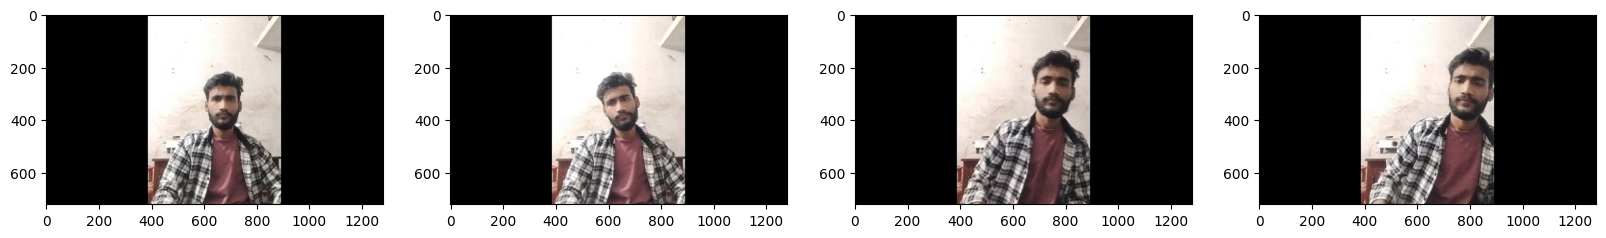

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 Manually Split Data into train test and val

In [94]:
113 * .7 #79 to train

79.1

In [95]:
113 * .15 # 17 and 17 to test and val

16.95

## 3.2 Move the Matching Labels

In [96]:
# for folder in ['train', 'test', 'val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
#         filename = file.split('.')[0]+'.json'
#         existing_filepath = os.path.join('data', 'labels', filename)
#         if os.path.exists(existing_filepath):
#             new_filepath = os.path.join('data', folder, 'labels', filename)
#             os.replace(existing_filepath, new_filepath)

# Albumentations

In [97]:
import albumentations as alb

In [98]:
img = cv2.imread(os.path.join('./model/data/test/images/5ddf1482-ae0d-11ef-b4ae-047c16c99ef2.jpg'))

In [99]:
img.shape

(720, 1280, 3)

In [100]:
augmentor = alb.Compose([
    alb.RandomCrop(width=1280, height=720),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
],bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotaition with OpenCv and JSON

In [101]:
img = cv2.imread(os.path.join('./model/data/train/images/5d4133e0-ae0d-11ef-87a6-047c16c99ef2.jpg'))

In [102]:
with open(os.path.join('./model/data/train/labels/5d4133e0-ae0d-11ef-87a6-047c16c99ef2.json'), 'r') as f:label = json.load(f)

In [103]:
label['shapes'][0]['points']

[[550.9756097560976, 206.3414634146342],
 [749.7560975609756, 446.5853658536586]]

### 4.3 Extract Cordintaes and Rescale to Match image Resolution

In [104]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [105]:
coords

[550.9756097560976, 206.3414634146342, 749.7560975609756, 446.5853658536586]

In [106]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [107]:
coords

[0.43044969512195125,
 0.2865853658536586,
 0.5857469512195121,
 0.6202574525745258]

### 4.4 Apply Augmentations and View Results

In [108]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

In [109]:
augmented['image'].shape

(720, 1280, 3)

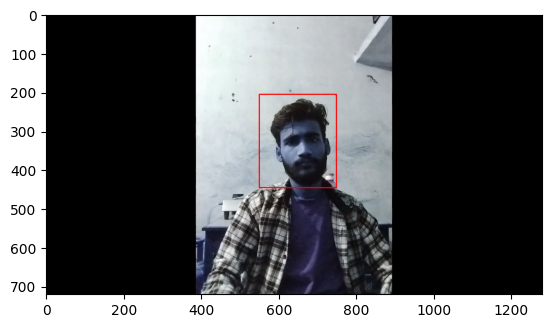

In [110]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [1280,720]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [1280, 720]).astype(int)),
              (255, 0, 0), 2)
plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [111]:
# base_path = './model/data'
# output_path = './model/aug_data'

# for partition in ['train', 'test', 'val']:
#     partition_path = os.path.join(base_path, partition)
#     images_path = os.path.join(partition_path, 'images')
#     labels_path = os.path.join(partition_path, 'labels')

#     aug_images_path = os.path.join(output_path, partition, 'images')
#     aug_labels_path = os.path.join(output_path, partition, 'labels')

#     # Create required directories if they don't exist
#     os.makedirs(aug_images_path, exist_ok=True)
#     os.makedirs(aug_labels_path, exist_ok=True)

#     for image_file in os.listdir(images_path):
#         image_path = os.path.join(images_path, image_file)
#         img = cv2.imread(image_path)

#         if img is None:
#             print(f"Could not read image: {image_file}")
#             continue

#         # Default bounding box coordinates
#         coords = [0, 0, 0.0001, 0.00001]
#         label_file = f'{os.path.splitext(image_file)[0]}.json'
#         label_path = os.path.join(labels_path, label_file)

#         # Load label if it exists
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label = json.load(f)

#             if 'shapes' in label and len(label['shapes']) > 0:
#                 coords[0] = label['shapes'][0]['points'][0][0]
#                 coords[1] = label['shapes'][0]['points'][0][1]
#                 coords[2] = label['shapes'][0]['points'][1][0]
#                 coords[3] = label['shapes'][0]['points'][1][1]
#                 coords = list(np.divide(coords, [1280, 720, 1280, 720]))

#         try:
#             # Generate augmentations
#             for x in range(60):
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

#                 # Save augmented image
#                 aug_image_file = f"{os.path.splitext(image_file)[0]}.{x}.jpg"
#                 cv2.imwrite(os.path.join(aug_images_path, aug_image_file), augmented['image'])

#                 # Prepare annotation
#                 annotation = {'image': aug_image_file}

#                 if os.path.exists(label_path):
#                     if len(augmented['bboxes']) == 0:
#                         annotation['bbox'] = [0, 0, 0, 0]
#                         annotation['class'] = 0
#                     else:
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1

#                 # Save annotation
#                 aug_label_file = f"{os.path.splitext(image_file)[0]}.{x}.json"
#                 with open(os.path.join(aug_labels_path, aug_label_file), 'w') as f:
#                     json.dump(annotation, f)

#         except Exception as e:
#             print(f"Error processing {image_file}: {e}")


### 5.2 Load Augmented Images to Tensorflow Dataset

In [112]:
train_images = tf.data.Dataset.list_files('./model/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [113]:
test_images = tf.data.Dataset.list_files('./model/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [114]:
val_images = tf.data.Dataset.list_files('./model/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [115]:
def load_labels(label_path):
    # Convert Tensor to string (label_path is a Tensor)
    label_path = label_path.numpy().decode('utf-8')
    
    with open(label_path, 'r', encoding="utf-8") as f:
        label = json.load(f)
        
    class_label = label.get('class', 0)  # Default to 0 if 'class' is missing
    bbox = label.get('bbox', [0.0, 0.0, 0.0, 0.0])  # Default to [0,0,0,0] if 'bbox' is missing
    
    # Return the class and bbox
    return [class_label], bbox


### 6.2 Load Labels to TensorFlow Dataset

In [116]:

train_labels = tf.data.Dataset.list_files('./model/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()


(array([1], dtype=uint8),
 array([0.4304, 0.3796, 0.586 , 0.7134], dtype=float16))

In [117]:

test_labels = tf.data.Dataset.list_files('./model/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [118]:
val_labels = tf.data.Dataset.list_files('./model/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [119]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4740, 4740, 1020, 1020, 1020, 1020)

### 7.2 Create Final Datasets (Images/Labels)

In [120]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8).prefetch(tf.data.AUTOTUNE)

In [121]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8).prefetch(tf.data.AUTOTUNE)

In [122]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8).prefetch(tf.data.AUTOTUNE)

### 7.3 View Imags and Annotations

In [123]:
data_samples = train.as_numpy_iterator().next()

In [124]:
res = data_samples  # Fetches the next batch of data

In [125]:
res[0].shape

(8, 120, 120, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


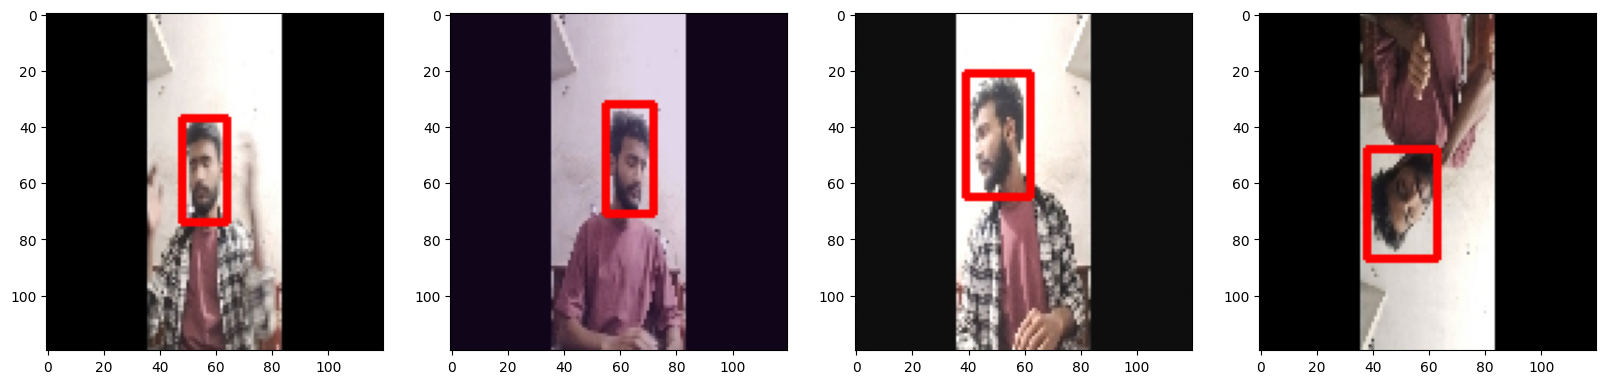

In [126]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    # Extract image and bounding box
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    # Create a writable copy of the image
    sample_image = sample_image.copy()
    
    # Calculate bounding box coordinates
    start_point = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
    end_point = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))
    
    # Draw the rectangle
    cv2.rectangle(sample_image, start_point, end_point, (255, 0, 0), 2)
    
    # Display the image
    ax[idx].imshow(sample_image)
plt.show()


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [127]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [128]:
vgg = VGG16(include_top=False)

In [129]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build Instance of Network

In [130]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    #Bounding box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [131]:
facetracker = build_model()

In [132]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [133]:
X, y = train.as_numpy_iterator().next()

In [134]:
y[0].shape, y[1].shape

((8, 1), (8, 4))

In [135]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 311ms/step


In [136]:
classes, coords

(array([[0.68817407],
        [0.6305122 ],
        [0.6433355 ],
        [0.6226097 ],
        [0.6799864 ],
        [0.65078086],
        [0.6892195 ],
        [0.6892195 ]], dtype=float32),
 array([[0.4214929 , 0.52980655, 0.6381891 , 0.2928214 ],
        [0.41713408, 0.46652424, 0.6062297 , 0.340148  ],
        [0.42511275, 0.4702404 , 0.5620592 , 0.36078638],
        [0.44269675, 0.5158434 , 0.6863228 , 0.3085357 ],
        [0.41653958, 0.41933602, 0.6244453 , 0.33633265],
        [0.41318697, 0.5180933 , 0.65128493, 0.3244491 ],
        [0.424389  , 0.4827023 , 0.6794684 , 0.3101794 ],
        [0.42438897, 0.48270229, 0.6794684 , 0.3101794 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [137]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1) / batches_per_epoch

In [138]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

### 9.2 Create Localization Loss and Classification Loss

In [139]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [140]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [141]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.099907>

In [142]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6128075>

In [143]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.099907>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [144]:

class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        print(batch)
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [145]:
print(train.element_spec)


(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))


In [146]:
model = FaceTracker(facetracker)

In [147]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [148]:
logdir='logs'

In [149]:
tensorboard_classback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [150]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_classback], verbose=1)

Epoch 1/40
(<tf.Tensor 'IteratorGetNext:0' shape=(None, 120, 120, 3) dtype=float32>, (<tf.Tensor 'IteratorGetNext:1' shape=<unknown> dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=<unknown> dtype=float16>))
(<tf.Tensor 'IteratorGetNext:0' shape=(None, 120, 120, 3) dtype=float32>, (<tf.Tensor 'IteratorGetNext:1' shape=<unknown> dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=<unknown> dtype=float16>))
 14/593 [..............................] - ETA: 13:22 - total_loss: 0.8071 - class_loss: 0.3163 - regress_loss: 0.6489

KeyboardInterrupt: 

In [ ]:
for batch in train.take(1):  # Replace `train` with your dataset name
    X, y = batch
    print("X shape:", X.shape)
    print("y[0] shape:", y[0].shape)
    print("y[1] shape:", y[1].shape)


X shape: (8, 120, 120, 3)
y[0] shape: (8,)
y[1] shape: (8, 4)
